In [ ]:
!mkdir /root/.kaggle
!echo '{"username":"nishagr","key":"4c177906d20e16c5b4bfa149719e7c39"}' > /root/.kaggle/kaggle.json 
!kaggle datasets download -d nishagr/applediseasedataset
!unzip /content/applediseasedataset.zip

In [2]:
import numpy as np
from fastai.vision import *
import matplotlib.pyplot as plt
import pandas as pd
EPOCHS = 10
INIT_LR = 1e-3
BS = 64
image_size = 256
directory_root = '/content/Apple/'
tfms = get_transforms(flip_vert=True, xtra_tfms=[rotate(degrees=(-180,180), p=0.5), 
                                                 brightness(change=(0.3, 0.7), p=0.5), 
                                                 contrast(scale=(0.5, 2.0), p=0.5),
                                                 symmetric_warp(magnitude=(-0.2,0.2), p=0.5)])
data = ImageDataBunch.from_folder(directory_root,
                                  size=image_size, bs=BS, ds_tfms=tfms)
print(f"[INFO] Data Normalization\n{data.normalize(imagenet_stats)}")

[INFO] Data Normalization
ImageDataBunch;

Train: LabelList (3071 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Apple___Black_rot,Apple___Black_rot,Apple___Black_rot,Apple___Black_rot,Apple___Black_rot
Path: /content/Apple;

Valid: LabelList (100 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Apple___Black_rot,Apple___Black_rot,Apple___Black_rot,Apple___Black_rot,Apple___Black_rot
Path: /content/Apple;

Test: None


[INFO] Batch Classes Examples



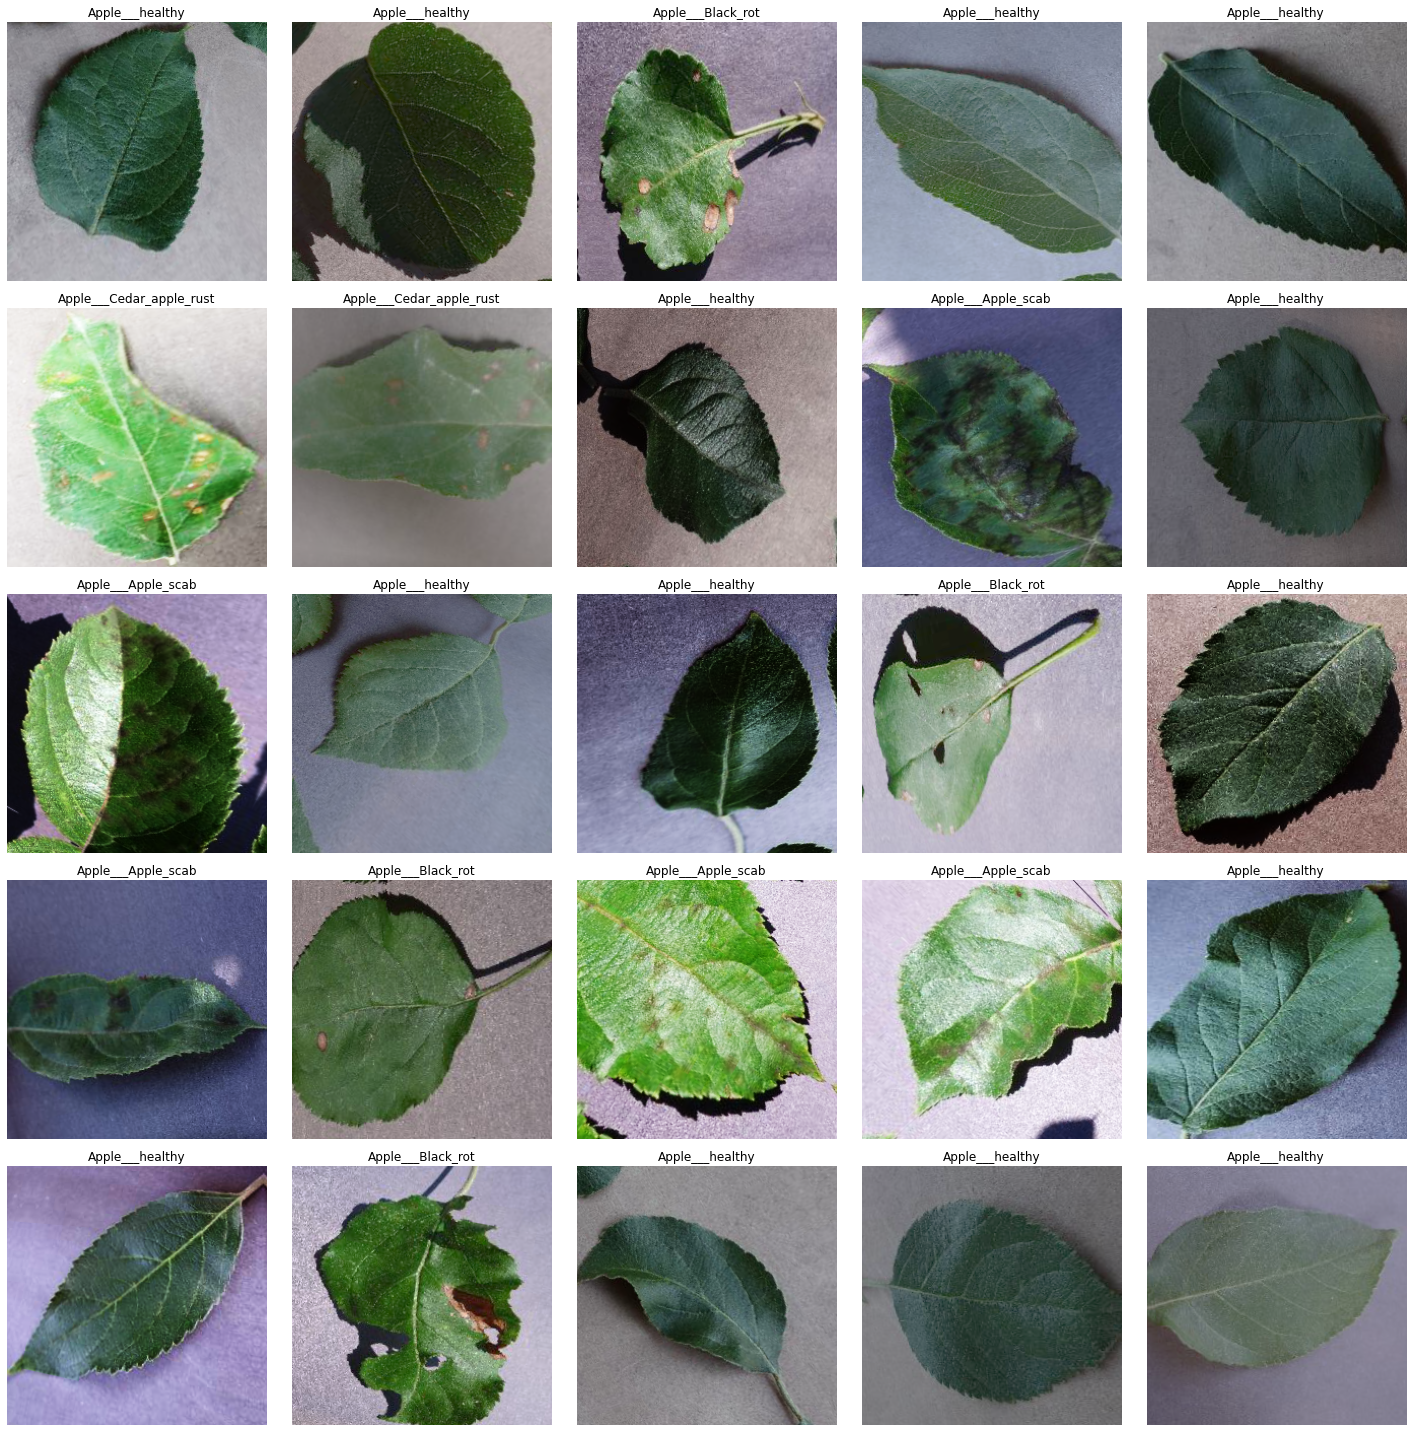

In [3]:
print(f"[INFO] Batch Classes Examples\n")
data.show_batch()

***ResNet-18 Model***

In [4]:
learn_resnet_18 = cnn_learner(data, models.resnet18, metrics=[accuracy, error_rate, 
               Precision(average='macro'),
               Recall(average='macro'),
               FBeta(average='macro')])
print(f"[INFO] Model Summary...\n{learn_resnet_18.summary()}")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



[INFO] Model Summary...
Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
__________________________

In [5]:
print("[INFO] training resnet network...")
learn_resnet_18.fit(EPOCHS, lr=INIT_LR)

[INFO] training resnet network...


In [6]:
train_indexes = []
train_count = pd.value_counts(data.train_ds.y.items)
for i in train_count.index:
  train_indexes.append(data.classes[i])
train_count.index = train_indexes
print(f"Training Images Count : \n{train_count}")

valid_indexes = []
valid_count = pd.value_counts(data.valid_ds.y.items)
for i in valid_count.index:
  valid_indexes.append(data.classes[i])
valid_count.index = valid_indexes
print(f"Testing Images Count : \n{valid_count}")

Training Images Count : 
Apple___healthy             1605
Apple___Apple_scab           610
Apple___Black_rot            601
Apple___Cedar_apple_rust     255
dtype: int64
Testing Images Count : 
Apple___healthy             40
Apple___Cedar_apple_rust    20
Apple___Black_rot           20
Apple___Apple_scab          20
dtype: int64


In [7]:
epochs = range(1, EPOCHS+1)

acc_resnet_18 = []
for i in range(EPOCHS):
  acc_resnet_18.append(learn_resnet_18.recorder.metrics[i][0]*100)
prcsn_resnet_18 = []
for i in range(EPOCHS):
  prcsn_resnet_18.append(learn_resnet_18.recorder.metrics[i][2])
rcl_resnet_18 = []
for i in range(EPOCHS):
  rcl_resnet_18.append(learn_resnet_18.recorder.metrics[i][3])
f1_resnet_18 = []
for i in range(EPOCHS):
  f1_resnet_18.append(2*(prcsn_resnet_18[i]*rcl_resnet_18[i])/(prcsn_resnet_18[i]+rcl_resnet_18[i]))

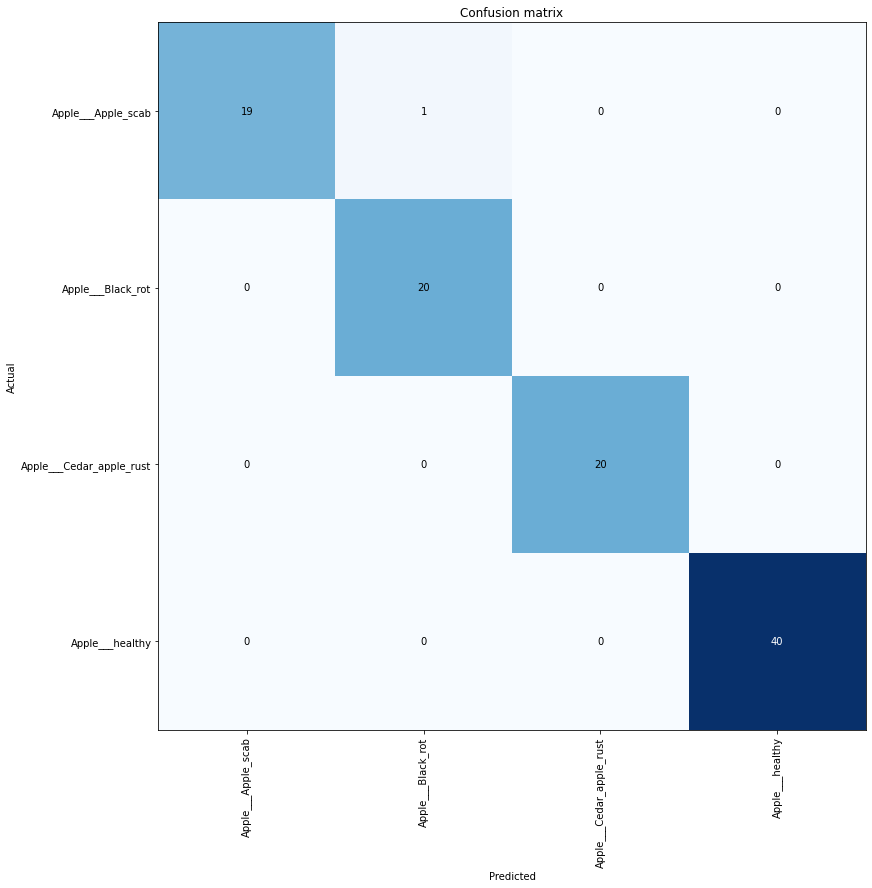

In [8]:
preds,y,losses = learn_resnet_18.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_resnet_18, preds, y, losses)
fig = interp.plot_confusion_matrix(return_fig=True)
fig.set_size_inches(25, 25)

In [9]:
print("[INFO] Calculating Final Results for ResNet-18...")
print(f"[INFO] Validation Accuracy : {acc_resnet_18[EPOCHS-1]}%")
print(f"[INFO] Precision : {prcsn_resnet_18[EPOCHS-1]}")
print(f"[INFO] Recall : {rcl_resnet_18[EPOCHS-1]}")
print(f"[INFO] F1-Score : {f1_resnet_18[EPOCHS-1]}")

[INFO] Calculating Final Results for ResNet-18...
[INFO] Validation Accuracy : 99.0%
[INFO] Precision : 0.988095223903656
[INFO] Recall : 0.987500011920929
[INFO] F1-Score : 0.9877975583076477


In [11]:
data = ImageDataBunch.from_folder(directory_root,
                                  train="train_segemented",
                                  valid="valid_segmented",
                                  size=image_size, bs=BS, ds_tfms=tfms)
print(f"[INFO] Data Normalization\n{data.normalize(imagenet_stats)}")

[INFO] Data Normalization
ImageDataBunch;

Train: LabelList (3071 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Apple___Black_rot,Apple___Black_rot,Apple___Black_rot,Apple___Black_rot,Apple___Black_rot
Path: /content/Apple;

Valid: LabelList (100 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Apple___Black_rot,Apple___Black_rot,Apple___Black_rot,Apple___Black_rot,Apple___Black_rot
Path: /content/Apple;

Test: None


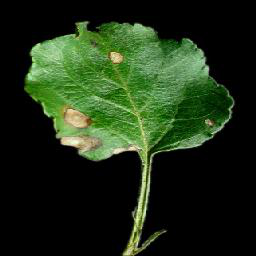

In [12]:
data.open(data.valid_ds.items[0])

In [13]:
learn_resnet_18 = cnn_learner(data, models.resnet18, metrics=[accuracy, error_rate, 
               Precision(average='macro'),
               Recall(average='macro'),
               FBeta(average='macro')])
print(f"[INFO] Model Summary...\n{learn_resnet_18.summary()}")

[INFO] Model Summary...
Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________

In [14]:
print("[INFO] training resnet network...")
learn_resnet_18.fit(EPOCHS, lr=INIT_LR)

[INFO] training resnet network...


In [15]:
train_indexes = []
train_count = pd.value_counts(data.train_ds.y.items)
for i in train_count.index:
  train_indexes.append(data.classes[i])
train_count.index = train_indexes
print(f"Training Images Count : \n{train_count}")

valid_indexes = []
valid_count = pd.value_counts(data.valid_ds.y.items)
for i in valid_count.index:
  valid_indexes.append(data.classes[i])
valid_count.index = valid_indexes
print(f"Testing Images Count : \n{valid_count}")

Training Images Count : 
Apple___healthy             1605
Apple___Apple_scab           610
Apple___Black_rot            601
Apple___Cedar_apple_rust     255
dtype: int64
Testing Images Count : 
Apple___healthy             40
Apple___Cedar_apple_rust    20
Apple___Black_rot           20
Apple___Apple_scab          20
dtype: int64


In [16]:
epochs = range(1, EPOCHS+1)

acc_resnet_18 = []
for i in range(EPOCHS):
  acc_resnet_18.append(learn_resnet_18.recorder.metrics[i][0]*100)
prcsn_resnet_18 = []
for i in range(EPOCHS):
  prcsn_resnet_18.append(learn_resnet_18.recorder.metrics[i][2])
rcl_resnet_18 = []
for i in range(EPOCHS):
  rcl_resnet_18.append(learn_resnet_18.recorder.metrics[i][3])
f1_resnet_18 = []
for i in range(EPOCHS):
  f1_resnet_18.append(2*(prcsn_resnet_18[i]*rcl_resnet_18[i])/(prcsn_resnet_18[i]+rcl_resnet_18[i]))

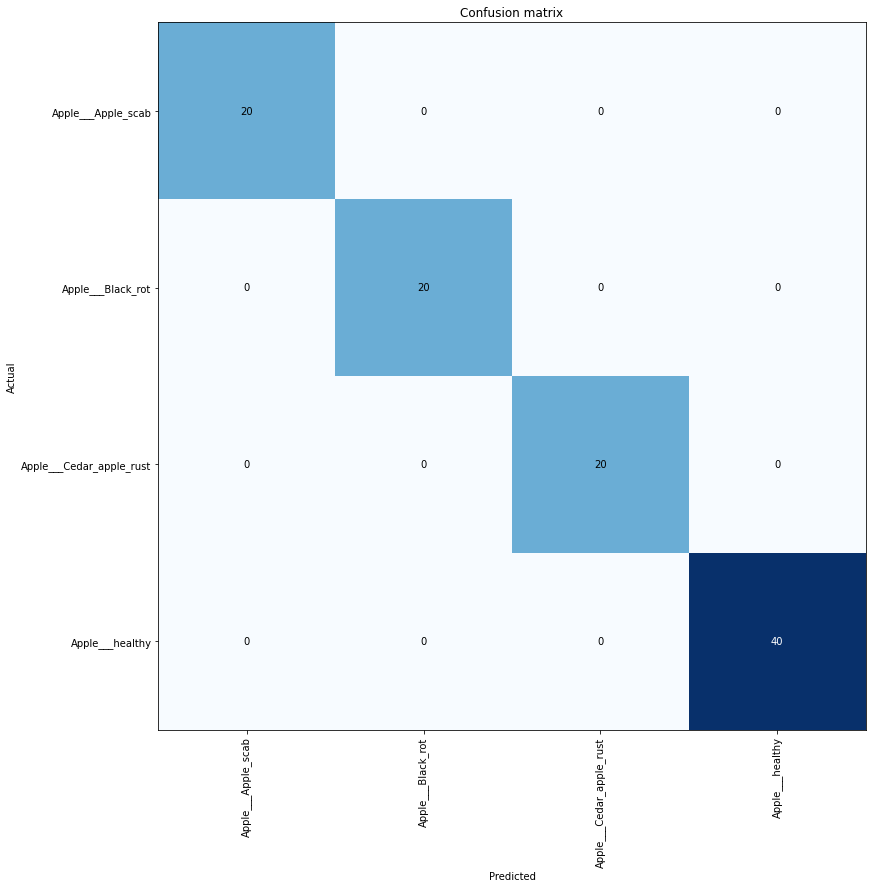

In [17]:
preds,y,losses = learn_resnet_18.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_resnet_18, preds, y, losses)
fig = interp.plot_confusion_matrix(return_fig=True)
fig.set_size_inches(25, 25)

In [18]:
print("[INFO] Calculating Final Results for ResNet-18...")
print(f"[INFO] Validation Accuracy : {acc_resnet_18[EPOCHS-1]}%")
print(f"[INFO] Precision : {prcsn_resnet_18[EPOCHS-1]}")
print(f"[INFO] Recall : {rcl_resnet_18[EPOCHS-1]}")
print(f"[INFO] F1-Score : {f1_resnet_18[EPOCHS-1]}")

[INFO] Calculating Final Results for ResNet-18...
[INFO] Validation Accuracy : 100.0%
[INFO] Precision : 1.0
[INFO] Recall : 1.0
[INFO] F1-Score : 1.0
